Weapon Model Mean Squared Error: 0.0895233486943158
Weapon Model R^2 Score: 0.998694109378787
Predicted average attack for first 5 weapons: [35.48666667 37.33333333 33.50166667 36.70666667 37.165     ]


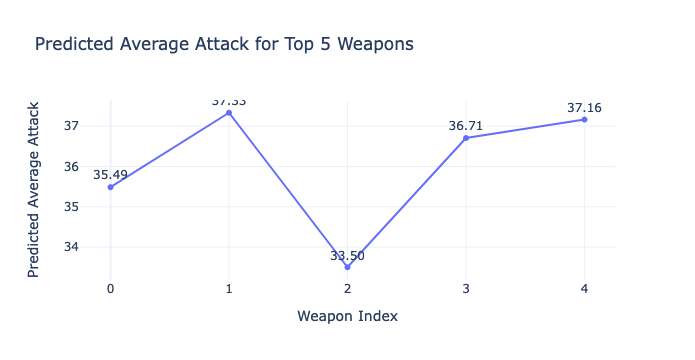

In [5]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go

# Load datasets
datasets = {
    'armors': pd.read_csv('/Users/sri00266/Desktop/elden_ring/data/armors.csv'),
    'weapons': pd.read_csv('/Users/sri00266/Desktop/elden_ring/data/weapons.csv')
}

# Data cleaning function
def clean_data(df, json_columns=[]):
    # Handle missing values
    df = df.dropna(subset=['id', 'name'])
    
    # Convert JSON strings to dicts
    for col in json_columns:
        def parse_json(x):
            if pd.isnull(x):
                return []
            try:
                return json.loads(x.replace("'", '"'))
            except (json.JSONDecodeError, TypeError):
                return []
        
        df[col] = df[col].apply(parse_json)
    
    return df

# Clean datasets
datasets['armors'] = clean_data(datasets['armors'], ['dmgNegation', 'resistance'])
datasets['weapons'] = clean_data(datasets['weapons'], ['attack', 'defence', 'scalesWith', 'requiredAttributes'])

# Calculate average attack power for weapons
def calculate_average_attack(attack_list):
    if len(attack_list) == 0:
        return 0
    return sum(d['amount'] for d in attack_list) / len(attack_list)

weapons_df = datasets['weapons']
weapons_df['average_attack'] = weapons_df['attack'].apply(calculate_average_attack)

# Calculate total damage negation and resistance for armors
def calculate_total_stat(stat_list):
    return sum(d['amount'] for d in stat_list) if len(stat_list) > 0 else 0

armors_df = datasets['armors']
armors_df['total_dmgNegation'] = armors_df['dmgNegation'].apply(calculate_total_stat)
armors_df['total_resistance'] = armors_df['resistance'].apply(calculate_total_stat)
armors_df['total_protection'] = armors_df['total_dmgNegation'] + armors_df['total_resistance']

# Prepare the data for training
X_weapons = weapons_df[['average_attack', 'weight']].values
y_weapons = weapons_df['average_attack'].values

X_train, X_test, y_train, y_test = train_test_split(X_weapons, y_weapons, test_size=0.2, random_state=42)

# Train a RandomForestRegressor model
weapon_model = RandomForestRegressor(n_estimators=100, random_state=42)
weapon_model.fit(X_train, y_train)

# Evaluate the model
y_pred = weapon_model.predict(X_test)
print(f"Weapon Model Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"Weapon Model R^2 Score: {r2_score(y_test, y_pred)}")

# Making predictions
predicted_attack = weapon_model.predict(X_weapons[:5])
print("Predicted average attack for first 5 weapons:", predicted_attack)

# Interactive line plot for weapon predictions with annotations
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(len(predicted_attack))),
    y=predicted_attack,
    mode='lines+markers+text',
    text=[f'{val:.2f}' for val in predicted_attack],
    textposition="top center",
    name='Predicted Attack'
))

fig.update_layout(
    title='Predicted Average Attack for Top 5 Weapons',
    xaxis_title='Weapon Index',
    yaxis_title='Predicted Average Attack',
    template='plotly_white'
)

fig.show()
